# Prep

*Install required packages before running the notebook*

In [3]:
! pip install yfinance
! pip install requests_cache
! pip install cvxpy
! pip install cvxopt
! pip install PyPortfolioOpt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 463.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.8/50.8 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 991.9 kB/s eta 0:00:00


Import packages/libraries and mount google drive

In [4]:
import pandas as pd
import numpy as np
import scipy.stats as si
import yfinance as yf
import requests_cache
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import cvxpy as cvx
import warnings
from scipy.stats import norm
from datetime import datetime
from copy import deepcopy
from tabulate import tabulate
from google.colab import drive

drive.mount('/content/drive')

warnings.filterwarnings('ignore')

%matplotlib inline

Mounted at /content/drive



---
# Question 1 (3 marks)
### Basic analysis and visualizations of the portfolio

**(a) Retrieve the daily prices of the 4 cryptos online (2020-2-1 to 2022-2-1) and calculate the daily log returns. (The same process as how we retrieved the stock prices in the tutorial.)**

Define helper function to download data and compute log returns.

In [5]:
session = requests_cache.CachedSession(cache_name='cache', backend='sqlite')

session.headers = {
    'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:89.0) Gecko/20100101 Firefox/89.0',
    'Accept': 'application/json;charset=utf-8'
}

def get_data_for_multiple_stocks(
    tickers: list[str],
    start_date: str,
    end_date: str,
) -> dict[list, pd.DataFrame]:
    """
    Function to download data for specfied tickers and time period.

    :param tickers: List of tickers to download data for
    :param start_date: Date from which to start pulling data
    :param end_date: Date at which to stop pulling data
    :return
        Dictionary containing financial data for specified tickers and time period
        key - ticker name, value - pandas dataframe containing data for that ticker
    """
    stocks = dict()
    format = '%Y-%m-%d'

    for ticker in tickers:
        s = yf.download(
            ticker,
            dt.datetime.strptime(start_date, format),
            dt.datetime.strptime(end_date, format)
        ).reset_index()

        s['log_ret'] = np.log(s['Adj Close'] / s['Adj Close'].shift(1))  # log_ret = log10(Pt / Pt-1)
        s['perc_ret'] = (s['Adj Close'] / s['Adj Close'].shift(1)) - 1  # perc_ret = Pt / Pt-1 - 1

        s.rename(columns={'Date': 'date', 'Adj Close': 'adj_close', 'Volume': 'volume'}, inplace=True)

        s = s[['date', 'adj_close', 'volume', 'log_ret', 'perc_ret']]

        stocks[ticker] = s

    print(f'Fetched financial data for {", ".join(tickers)} from {start_date} to {end_date}.')

    return stocks

Pull financial data for the following tickers:
* BTC-USD
* ETH-USD
* DOGE-USD
* MATIC-USD

Time period: 2020-02-01 to 2022-02-01

In [6]:
tickers_to_pull = ['BTC-USD', 'ETH-USD', 'DOGE-USD', 'MATIC-USD']
start_date, end_date = '2020-02-01', '2022-02-02'

og_data = get_data_for_multiple_stocks(
    tickers=tickers_to_pull,
    start_date=start_date,
    end_date=end_date
)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetched financial data for BTC-USD, ETH-USD, DOGE-USD, MATIC-USD from 2020-02-01 to 2022-02-02.


Preview data for one of the tickers, BTC-USD

In [7]:
og_data['BTC-USD'].head(), og_data['BTC-USD'].shape

(        date    adj_close       volume   log_ret  perc_ret
 0 2020-02-01  9392.875000  25922656496       NaN       NaN
 1 2020-02-02  9344.365234  30835736946 -0.005178 -0.005165
 2 2020-02-03  9293.521484  30934096509 -0.005456 -0.005441
 3 2020-02-04  9180.962891  29893183716 -0.012185 -0.012112
 4 2020-02-05  9613.423828  35222060874  0.046028  0.047104,
 (732, 5))

**(b) For this period, plot the asset return correlations using a matrix heatmap, and plot the annualized Sharpe ratios of the four crypto assets using a bar chat.**

Prepare asset returns data for plotting

In [8]:
og_data_b = deepcopy(og_data)
log_ret_df = pd.DataFrame()
log_ret_df['date'] = og_data_b['BTC-USD']['date']
for kv_pair in og_data_b.items():
    ticker, df = kv_pair
    df.rename(columns={'log_ret': f'{ticker}'}, inplace=True)
    log_ret_df = pd.concat([log_ret_df, df[f'{ticker}']], axis=1)

# clean the dataframe
log_ret_df.dropna(inplace=True)
log_ret_df.set_index('date', inplace=True)

log_ret_df.head()

,BTC-USD,ETH-USD,DOGE-USD,MATIC-USD
date,,,,
2020-02-02,-0.005178,0.026559,0.018814,0.041880
2020-02-03,-0.005456,0.006592,-0.011410,0.144471
2020-02-04,-0.012185,-0.003242,0.025492,-0.044297
2020-02-05,0.046028,0.076176,0.031074,0.014285
2020-02-06,0.012033,0.038936,0.027127,0.132067


Plot matrix heatmaps

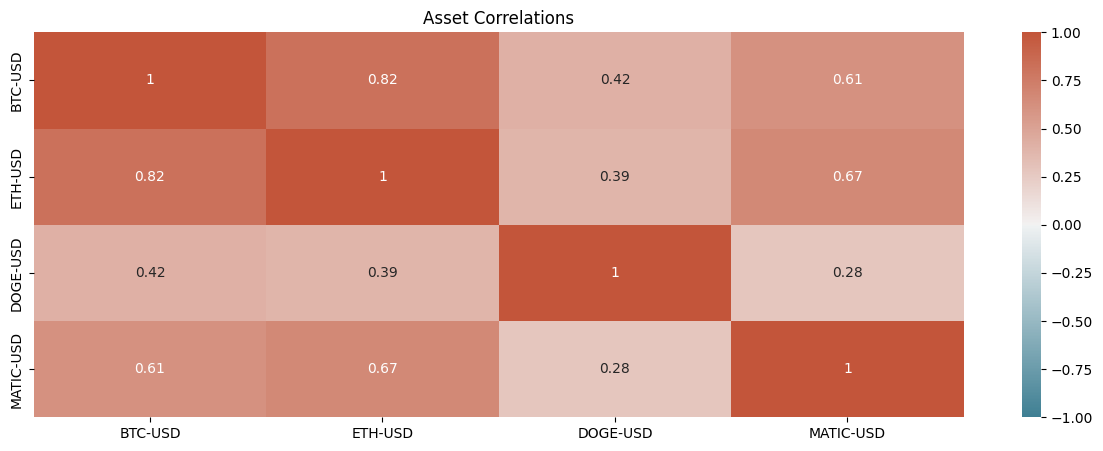

In [9]:
plt.figure(figsize=(15, 5))
sns.heatmap(round(log_ret_df.corr(), 2), cmap=sns.diverging_palette(220, 20, as_cmap=True), annot=True, vmin=-1, vmax=1)
plt.title('Asset Correlations')
plt.show()

Compute sharpe ratio for each asset and plot the results. The formula for calculating the annualized sharpe ratio is given as:

$S_a = \frac{E[R_p - R_f]}{\sigma_p} \times \sqrt{T}$

* Crpyto trades occur 24/7, 365 times a year (i.e $T$ = 365)
* $R_f$ is assumed to be 0%

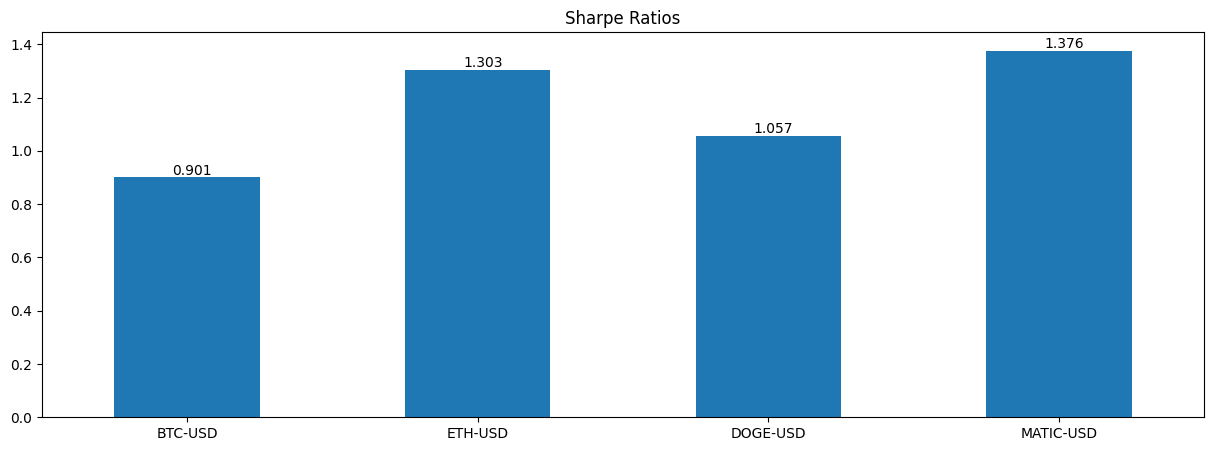

In [10]:
ax = round(log_ret_df.mean(axis=0) / log_ret_df.std(axis=0) * 365**0.5, 3).plot(kind='bar', figsize=(15, 5))
plt.xticks(rotation=0)
plt.title('Sharpe Ratios')

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + 0.2, p.get_height() + 0.01))

**(c) What can you observe? (< 100 words)**

All of the 4 assets' returns in the portfolio are quite strongly correlated with each other. This would mean that diversification as a form of risk management would not be effective in this portfolio.

---
# Question 2 (5 marks)
### Markowitz MVO and simulated portfolio value

**(a) Assume we are long only, with total weights equal to 1, run a Mean-Variance Optimization on
the crypto assets to minimize risk. Plot the resultant holding weights for two constraint settings, one with the maximum holding weight limit to 0.5, and one with no limit on maximum holding weight. So you will have two graphs, each has 4 lines of different colors. Each line has 731 values between 0-1, representing the holding weight for that asset on each day.**

Prepare data

In [11]:
data_q2 = get_data_for_multiple_stocks(
    tickers=tickers_to_pull,
    start_date='2019-05-01',  # earliest available data for MATIC-USD starts from 2019-05-01
    end_date='2022-02-02'
)

simple_ret_df = pd.DataFrame()
for kv_pair in data_q2.items():
    ticker, df = kv_pair
    df.rename(columns={'perc_ret': f'{ticker}'}, inplace=True)
    simple_ret_df = pd.concat([simple_ret_df, df[f'{ticker}']], axis=1)

# clean the dataframe
simple_ret_df.dropna(inplace=True)
simple_ret_df.reset_index(drop=True, inplace=True)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetched financial data for BTC-USD, ETH-USD, DOGE-USD, MATIC-USD from 2019-05-01 to 2022-02-02.


Perform Markowitz MVO and compute optimized portfolio returns

In [ ]:
shape = (len(simple_ret_df), 4)
constrained_weights, unconstrained_weights = [], []

for idx in range(len(simple_ret_df)):

    freq = 180
    start_idx, end_idx = idx, idx + freq

    df = simple_ret_df[start_idx:end_idx]  # sliding window of 180 days

    if len(df) == freq:

        num_assets = len(df.columns)
        w = cvx.Variable(num_assets)

        # compute the returns' expected mean
        total_return_log = np.log(df + 1)
        total_return_log = df.sum().to_numpy()
        total_simple_return = np.exp(total_return_log) - 1
        horizon_length = df.shape[1]
        expected_mean = (1 + total_simple_return) ** (1 / horizon_length) - 1

        # compute the portfolio volatility
        cvm = df.cov()  # portfolio covariance matrix
        portfolio_variance = cvx.quad_form(w, cvm)

        # set maximum weight constraint and returns scale
        max_weight = 0.5
        returns_scale = 0.0001

        # define constraints
        constraints = [
            w >= 0,  # weights must be non-negative
            w <= max_weight,  # weights cannot exceed the max holding weight
            sum(w) == 1  # sum of weights must be 1
        ]

        portfolio_return = sum(cvx.multiply(expected_mean, w))

        # define objective function
        objective = cvx.Minimize(portfolio_variance - returns_scale * portfolio_return)
        problem = cvx.Problem(objective, constraints)

        # solve optimization problem for constrained portfolio
        problem.solve()
        weights_constrained = w.value

        # solve optimization problem for unconstrained portfolio
        constraints.pop(1)  # remove max_weight constraint (second constraint)
        problem = cvx.Problem(objective, constraints)
        problem.solve()
        weights_unconstrained = w.value

        # save results
        constrained_weights.append(weights_constrained)
        unconstrained_weights.append(weights_unconstrained)

# format results into a dataframe
constrained_weights_df = pd.DataFrame(constrained_weights)
unconstrained_weights_df = pd.DataFrame(unconstrained_weights)

# format column names
columns = {0: 'BTC-USD', 1: 'ETH-USD', 2: 'DOGE-USD', 3: 'MATIC-USD'}
constrained_weights_df.rename(columns=columns, inplace=True)
unconstrained_weights_df.rename(columns=columns, inplace=True)

Plot the results of the Markowitz MVO

In [ ]:
constrained_weights_df.plot(figsize=(15, 5))
plt.title('Constrained Weights Plot')
plt.ylabel('Weights')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

unconstrained_weights_df.plot(figsize=(15, 5))
plt.title('Unconstrained Weights Plot')
plt.ylabel('Weights')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

**(b) Report the annualized returns and volatilites for the two portfolio settings and compare the results.**

Helper function to compute weighted portfolio returns

In [ ]:
def compute_weighted_log_returns(
    df: pd.DataFrame,
    weights: pd.DataFrame,
    is_log: bool = False
) -> pd.Series:
    """
    Function to compute a portfolio's weighted log returns

    :param df: Dataframe containing portfolio's log returns
    :param weights: Dataframe containing each asset's weights
    :param is_simple: Whether input df's returns are in simple or logarithmic form
    :return Dataframe containing the weighted returns
    """

    # convert log returns to simple returns before weighting
    weighted_returns = (np.exp(df) - 1) * weights if is_log else df * weights

    # sum up assets' weighted returns
    weighted_returns = np.sum(weighted_returns, axis=1)

    # convert simple returns back to log returns
    weighted_returns = np.log(weighted_returns + 1)

    return weighted_returns

Calculate the portfolio's weighted returns

In [ ]:
simple_ret_df_trimmed = simple_ret_df[-len(unconstrained_weights_df):].reset_index(drop=True)
constrained_weighted_log_ret_df = compute_weighted_log_returns(
    df=simple_ret_df_trimmed,
    weights=constrained_weights_df
)
unconstrained_weighted_log_ret_df = compute_weighted_log_returns(
    df=simple_ret_df_trimmed,
    weights=unconstrained_weights_df
)

compiled_weighted_log_ret_df = pd.concat([constrained_weighted_log_ret_df, unconstrained_weighted_log_ret_df], axis=1)
compiled_weighted_log_ret_df.rename(columns={0: 'constrained_weights', 1: 'unconstrained_weights'}, inplace=True)

Annualized log returns and volatility can be calculated as follows:

$Annualized\ Log\ Returns = E[R] \times {T}$ <br>
$Annualized\ Volatility = {\sigma_{R}} \times \sqrt{T}$

Compute and report the annualized returns and volatility for both weights settings

In [ ]:
# compute annualized returns and volatility based on the formulas above
annualized_log_ret = compiled_weighted_log_ret_df[-732:].mean(axis=0) * 365
annualized_vol = compiled_weighted_log_ret_df[-732:].std(axis=0) * 365**0.5

cw_ar, uncw_ar = annualized_log_ret['constrained_weights'], annualized_log_ret['unconstrained_weights']
cw_av, uncw_av = annualized_vol['constrained_weights'], annualized_vol['unconstrained_weights']

# format results
results = tabulate([
    ['', 'Constrained Weights', 'Unconstrained Weights'],
    ['Annualized Log Returns', round(cw_ar, 4), round(uncw_ar, 4)],
    ['Annualized Volatility', round(cw_av, 4), round(uncw_av, 4)],
    ['Sharpe Ratio', round(cw_ar / cw_av, 4), round(uncw_ar / uncw_av, 4)]
], headers='firstrow', numalign='center', stralign='center', tablefmt='presto')

# report results
print(results)

---
# Question 3 (4 marks)
### Calculate the VaR (5%) for the component assets

**(a) At α = 5% level, estimate daily VaR and ES of the percentage return (not value) of: all the
individual component crypto assets and the portfolio (no limit to holding weights setting). Plot
and show the VaR and ES curves for one year (2021-2-1 to 2022-2-1). So you will have 5
graphs, each has two lines of different colors (VaR and ES).**

Prepare data

In [ ]:
data_q3 = get_data_for_multiple_stocks(
    tickers=tickers_to_pull,
    start_date='2020-02-01',
    end_date='2022-02-02'
)
weights = unconstrained_weights_df.copy(deep=True).reset_index(drop=True)  # no limit on holding weights setting
weights = weights.iloc[-732:].reset_index(drop=True)
alpha = 0.05
z_alpha = norm.ppf(alpha, loc=0, scale=1)  # z-score for parametric method

ptf_df_q3 = pd.DataFrame()
ptf_df_q3['date'] = data_q3['BTC-USD']['date']

for ticker in ('BTC-USD', 'ETH-USD', 'MATIC-USD', 'DOGE-USD'):
    ptf_df_q3[ticker] = data_q3[ticker]['perc_ret'] * weights[ticker]
ptf_df_q3['perc_ret'] = ptf_df_q3['BTC-USD'] + ptf_df_q3['ETH-USD'] + ptf_df_q3['MATIC-USD'] + ptf_df_q3['DOGE-USD']

data_q3['PTF'] = ptf_df_q3.copy(deep=True)

Estimate VaR and ES (5%) using Historical Simulations and Parametric methods

In [ ]:
for ticker in data_q3.keys():

    new_df = data_q3[ticker].copy(deep=True).dropna().reset_index(drop=True)
    # new_df['weighted_perc_ret'] = new_df['perc_ret'] * weights[ticker]  # weight returns before computations

    for idx in range(len(new_df)):

        # get past 365 days of data (sliding window)
        start_idx, end_idx = idx - 364, idx
        past_365 = new_df.loc[start_idx:end_idx, 'perc_ret']
        past_365.dropna(inplace=True)

        # update results
        if len(past_365) == 365:

            # compute VaR and ES [Historical Simulations]
            VaR_95_HS = past_365.quantile(alpha)  # take returns that are in the 5th percentile
            ES_95_HS = np.mean(past_365[past_365 < VaR_95_HS])

            # compute VaR and ES [Parametric]
            mu = past_365.mean()
            sigma = past_365.std()
            VaR_95_Para = mu + sigma * z_alpha
            ES_95_Para = (norm.pdf(z_alpha, loc=0, scale=1) * sigma) / (1 - (100 - (alpha * 100)) / 100)

            # add results to dataframe
            new_df.loc[idx, 'VaR_95_HS'], new_df.loc[idx, 'ES_95_HS'] = VaR_95_HS, ES_95_HS
            new_df.loc[idx, 'VaR_95_Para'], new_df.loc[idx, 'ES_95_Para'] = VaR_95_Para, ES_95_Para

        else:
            new_df.loc[idx, 'VaR_95_HS'], new_df.loc[idx, 'ES_95_HS'] = np.nan, np.nan
            new_df.loc[idx, 'VaR_95_Para'], new_df.loc[idx, 'ES_95_Para'] = np.nan, np.nan

    # update df for each asset after computing VaR
    data_q3[ticker] = new_df.reset_index(drop=True)

Plot VaR (5%) curves for our Crypto assets

In [ ]:
# trim period to 2021-02-01 - 2022-02-1 for plotting
for ticker in data_q3.keys():
    df = data_q3[ticker].copy(deep=True)
    df = df[df['date'] >= '2021-02-01']
    data_q3[ticker] = df

plt.figure(figsize=(15, 10))
plt.plot(data_q3['BTC-USD']['date'], -data_q3['BTC-USD']['VaR_95_HS'], 'g-', label='BTC-USD HS')
plt.plot(data_q3['ETH-USD']['date'], -data_q3['ETH-USD']['VaR_95_HS'], 'b-', label='ETH-USD HS')
plt.plot(data_q3['DOGE-USD']['date'], -data_q3['DOGE-USD']['VaR_95_HS'], 'r-', label='DOGE-USD HS')
plt.plot(data_q3['MATIC-USD']['date'], -data_q3['MATIC-USD']['VaR_95_HS'], 'y-', label='MATIC-USD HS')
plt.plot(data_q3['PTF']['date'], -data_q3['PTF']['VaR_95_HS'], 'm-', label='Portfolio HS')
plt.plot(data_q3['BTC-USD']['date'], -data_q3['BTC-USD']['VaR_95_Para'], 'g--', label='BTC-USD Parametric')
plt.plot(data_q3['ETH-USD']['date'], -data_q3['ETH-USD']['VaR_95_Para'], 'b--', label='ETH-USD Parametric')
plt.plot(data_q3['DOGE-USD']['date'], -data_q3['DOGE-USD']['VaR_95_Para'], 'r--', label='DOGE-USD Parametric')
plt.plot(data_q3['MATIC-USD']['date'], -data_q3['MATIC-USD']['VaR_95_Para'], 'y--', label='MATIC-USD Parametric')
plt.plot(data_q3['PTF']['date'], -data_q3['PTF']['VaR_95_Para'], 'm--', label='Portfolio Parametric')
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Value At Risk')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
locs, labels = plt.xticks()
plt.setp(labels, rotation=0)
plt.title('Value-at-Risk (5%) Using Historical Simulations and Parametric Methods')
plt.show()

Plot ES (5%) curves for our Crypto assets

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(data_q3['BTC-USD']['date'], -data_q3['BTC-USD']['ES_95_HS'], 'g-', label='BTC-USD HS')
plt.plot(data_q3['ETH-USD']['date'], -data_q3['ETH-USD']['ES_95_HS'], 'b-', label='ETH-USD HS')
plt.plot(data_q3['DOGE-USD']['date'], -data_q3['DOGE-USD']['ES_95_HS'], 'r-', label='DOGE-USD HS')
plt.plot(data_q3['MATIC-USD']['date'], -data_q3['MATIC-USD']['ES_95_HS'], 'y-', label='MATIC-USD HS')
plt.plot(data_q3['PTF']['date'], -data_q3['PTF']['ES_95_HS'], 'm-', label='Portfolio HS')
plt.plot(data_q3['BTC-USD']['date'], data_q3['BTC-USD']['ES_95_Para'], 'g--', label='BTC-USD Parametric')
plt.plot(data_q3['ETH-USD']['date'], data_q3['ETH-USD']['ES_95_Para'], 'b--', label='ETH-USD Parametric')
plt.plot(data_q3['DOGE-USD']['date'], data_q3['DOGE-USD']['ES_95_Para'], 'r--', label='DOGE-USD Parametric')
plt.plot(data_q3['MATIC-USD']['date'], data_q3['MATIC-USD']['ES_95_Para'], 'y--', label='MATIC-USD Parametric')
plt.plot(data_q3['PTF']['date'], data_q3['PTF']['ES_95_Para'], 'm--', label='Portfolio Parametric')
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Expected Shortfall')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
locs, labels = plt.xticks()
plt.setp(labels, rotation=0)
plt.title('Expected Shortfall (5%) Using Historical Simulations and Parametric Methods')
plt.show()

**(b) Identify the most risky component asset from the above evidence and justify your choice. (<100 words)**

DOGE-USD is the most risky component asset. It has the highest VaR and ES at alpha=5% level.

# Question 4 (6 marks)
### Hedge by Options

**(a) Compare Bitcoin (BTC-USD) and Ether (ETH-USD), which coins' prices do you think is more volatile? (You can choose to also consider the upside and downside risks separately)**

Visualize price data

In [ ]:
# prepare price data for BTC-USD and ETH-USD
btc_df = og_data['BTC-USD'].copy(deep=True)
eth_df = og_data['ETH-USD'].copy(deep=True)

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(btc_df['date'], btc_df['log_ret'], '-b', label='BTC-USD')
plt.plot(eth_df['date'], eth_df['log_ret'], '-g', label='ETH-USD')
plt.title('Log Returns for Bitcoin & Ethereum')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

Compute and compare the annualized metrics for both tickers

In [ ]:
# calculate annualized volatility for their log returns
btc_av = btc_df['log_ret'].std() * 365**0.5
eth_av = eth_df['log_ret'].std() * 365**0.5

# calculate average of their log returns considering only upside risks
btc_upside = btc_df[btc_df['log_ret'] > 0]['log_ret'].mean()
eth_upside = eth_df[eth_df['log_ret'] > 0]['log_ret'].mean()

# calculate average of their log returns considering only downside risks
btc_downside = btc_df[btc_df['log_ret'] <= 0]['log_ret'].mean()
eth_downside = eth_df[eth_df['log_ret'] <= 0]['log_ret'].mean()

results = tabulate([
    ['', 'BTC-USD', 'ETH-USD'],
    ['Annualized Volatility', round(btc_av, 3), round(eth_av, 3)],
    ['Average Returns (Upside)', round(btc_upside, 3), round(eth_upside, 3)],
    ['Average Returns (Downside)', round(btc_downside, 3), round(eth_downside, 3)]
], headers='firstrow', numalign='center', tablefmt='presto')

print(results)

**(b) Download the file ‘okex_option_trade.csv’ (BTC’s and ETH’s call and put options trade data). (Take the first row instrument here for example, in the instrument_id: “BTC-USD” refers to the underlying asset, “210226” refers to its expiration date which is 2021/02/26, “US$7000” is the strike price. You can take the price column as the market price. That means, on 2020/12/17, someone bought qty=1 unit of this instrument at a price of BTC 0.001, so this put option price at that timestamp is BTC 0.001)**

***Note that:***

***1) The data file is not chronologically ordered by timestamps, you may need to perform some data sorting/filtering.***

***2) Assume you will not have liquidity issue, that is, you can successfully buy any quantity of the instrument at the given market prices, with no spread or fees.***

**For your no limit setting portfolio from Q2, on 2021/01/01, for each one unit of the asset your team deemed to be the most volatile, buy one straddle (buy one put + buy one call) that expires on 2021/01/08. You can choose the exercise prices as close as to minus/plus one standard deviation of asset return (minus one standard deviation for buying a put and plus one standard deviation for buying a call option. You can determine your cost using the last transacted option prices on 2021/01/01 as the market price. Suppose your cost is externally financed and to be returned/deducted on 2021/01/08, with no interest rate. What are the instrument_ids that you decided to buy?**

Read CSV file into dataframe

In [ ]:
file_path = '/content/drive/My Drive/bt4016/ashwin/OKEx_options_trade.csv'
okex_options_trade_df = pd.read_csv(file_path)

okex_options_trade_df.head()

As seen from the above output, the dataframe needs to be cleaned. We will perform some simple operations to tidy up the dataframe

In [ ]:
def clean_options_df(df: pd.DataFrame) -> pd.DataFrame:

    options_df = okex_options_trade_df[okex_options_trade_df['side'] != 'side'].dropna()

    options_df['date'] = pd.to_datetime(options_df['timestamp'].apply(lambda x: x[:10]))

    options_df['underlying_asset'] = options_df['instrument_id'].apply(lambda x: x[:7])

    options_df['expiration_date'] = options_df['instrument_id'].apply(lambda x: '20'+ str(x[8:14]))
    options_df['expiration_date'] = options_df['expiration_date'].apply(lambda x: datetime.strptime(x, '%Y%m%d'))

    options_df['strike_price_temp'] = options_df['instrument_id'].apply(lambda x: x[15:])
    options_df['strike_price'] = options_df['strike_price_temp'].apply(lambda x: x[:-2])
    options_df['strike_price'] = options_df['strike_price'].replace('', np.nan).astype(float)

    options_df['contract_type'] = options_df['instrument_id'].apply(lambda x: 'put' if x[-1] == 'P' else 'call')

    options_df.drop(columns=['strike_price_temp', 'Unnamed: 0'], inplace=True)
    options_df.dropna(inplace=True)
    options_df.reset_index(drop=True, inplace=True)

    options_df['price'] = options_df['price'].astype('float')

    options_df['days_to_expiry'] = options_df['expiration_date'] - options_df['date']
    options_df['days_to_expiry'] = options_df['days_to_expiry'].apply(lambda x: x.days)

    return options_df

options_df = clean_options_df(okex_options_trade_df)

options_df.head()

From our results in 4(a), we can see that Ether is more volatile than Bitcoin. Hence, we will be purchasing a straddle with Ether as its underlying asset that expires on 2021/01/08.

In [ ]:
purchase_date, expiration_date = '2021-01-01', '2021-01-08'
eth_options = options_df.copy(deep=True)[options_df['underlying_asset'] == 'ETH-USD']

eth_options = eth_options[
    (eth_options['date'] == purchase_date) &
    (eth_options['expiration_date'] == expiration_date)
]

eth_call = eth_options[eth_options['contract_type'] == 'call']
eth_put = eth_options[eth_options['contract_type'] == 'put']

eth_call.reset_index(drop=True, inplace=True)
eth_put.reset_index(drop=True, inplace=True)

Value the options using the Black Scholes Model.

$Call\,Price\,(C) = SN(d_{1})-Xe^{-rt}N(d_{2})$ <br>
$Put\,Price\,(P) = Xe^{-rt}N(-d_{2})-SN(-d_{1})$ <br>

Where, <br>
$d_1 = \left( \frac{ln(S/X) + (r + \sigma^2/2)t}{\sigma * t^{0.5}} \right)$,
$d_2 = \left( \frac{ln(S/X) + (r - \sigma^2/2)t}{\sigma * t^{0.5}} \right)$ <br>

Helper functions to compute call, put prices & overall profit

In [ ]:
def get_call_value(S, X, T, r, sigma):
    """
    Formula for obtaining price of european call options using the BSM
    :param S: current stock price
    :param X: strike price
    :param T: time to maturity
    :param r: interest rate
    :param sigma: volatility of underlying asset, daily
    :return value of a call contract
    """

    d1 = (np.log(S / X) + (r + sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / X) + (r - sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))

    call = (S * si.norm.cdf(d1, 0.0, 1.0) - X * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0))

    return call

def get_put_value(S, X, T, r, sigma):
    """
    Formula for obtaining price of european put options using the BSM
    :param S: current stock price
    :param X: strike price
    :param T: time to maturity
    :param r: interest rate
    :param sigma: volatility of underlying asset, daily
    :return value of a put contract
    """

    d1 = (np.log(S / X) + (r + sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / X) + (r - sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))

    put = (X * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0) - S * si.norm.cdf(-d1, 0.0, 1.0))

    return put

def compute_option_profit(S1, K, cost, is_call):
    """ Function to compute the payoff of a call/put option """

    payoff = max(S1 - K, 0) if is_call else max(K - S1, 0)
    profit = payoff - cost

    return profit

In [ ]:
S0 = float(og_data['ETH-USD'].loc[og_data['ETH-USD']['date'] == '2021-01-01']['adj_close'])
S1 = float(og_data['ETH-USD'].loc[og_data['ETH-USD']['date'] == '2021-01-08']['adj_close'])

eth_call['S0'] = S0
eth_call['price_usd'] = eth_call['S0'] * eth_call['price']

Value the options contracts

In [ ]:
eth_call['option_profit'] = eth_call.apply(
    lambda df: compute_option_profit(
        S1, df['strike_price'], df['price_usd'], True
    ), axis=1
)

In [ ]:
daily_vol = eth_av / (365**0.5)  # undo the annualization

eth_call['value_BSM'] = eth_call.apply(
    lambda df: get_call_value(
        S0, df['strike_price'], 7, 0, daily_vol
    ), axis=1
)

eth_call.head()

Get most profitable contracts

In [ ]:
eth_call['upside'] = eth_call['value_BSM'] / eth_call['price_usd'] - 1

eth_call.sort_values('upside', ascending=False).head(3)

# Question 5 (8 marks)
### Options Trading Strategy

**(a) For your no limit setting portfolio from Q2, on any date throughout the two years, you are
allowed to decide your favored frequency, and buy or sell any quantity of options as long as
that option has a trading record on that date based on the data file. (Again, similar to Q4,
assuming that you can successfully buy the instrument of any quantity at the last transacted
prices. E.g., if your strategy decide to buy one call at 4:00PM, you may use the price at 3:58PM
as the market price.) Clearly explain your strategy: what is the intuition? why do you design
it in such a way.**

Extract data

In [ ]:
data_q5 = get_data_for_multiple_stocks(
    tickers=tickers_to_pull,
    start_date='2019-05-01',
    end_date='2022-02-02'
)

weights_q5 = unconstrained_weights_df.copy(deep=True)

Prepare data

In [ ]:
tickers_to_trade = ['BTC-USD', 'ETH-USD']

df_ptf = pd.DataFrame()
df_ptf['Date'] = data_q5['BTC-USD']['date'][-828:].reset_index(drop=True)
for ticker in tickers_to_pull:
    new_df = pd.DataFrame()
    new_df[f'{ticker}_PRICE'] = data_q5[ticker].copy(deep=True)[-828:][['adj_close']].reset_index(drop=True)
    new_df[f'{ticker}_WGT'] = weights_q5[ticker].copy(deep=True)
    df_ptf = pd.concat([df_ptf, new_df], axis=1)

df_ptf['PTF_LOG_RET'] = compiled_weighted_log_ret_df['unconstrained_weights'].copy(deep=True)
df_ptf['PTF_RET'] = np.exp(df_ptf['PTF_LOG_RET']) - 1

df_ptf = df_ptf[df_ptf['Date'] >= '2020-02-01'].reset_index(drop=True)

Compute returns

In [ ]:
for ticker in tickers_to_pull:
    df_ptf[f'{ticker}_RET'] = df_ptf[f'{ticker}_PRICE'] / df_ptf[f'{ticker}_PRICE'].shift(1) - 1
    df_ptf[f'{ticker}_LOG_RET'] = np.log(df_ptf[f'{ticker}_PRICE'] / df_ptf[f'{ticker}_PRICE'].shift(1))

Compute technical indicators, Short & Long Term Moving Averages (STMA & LTMA)

*   STMA: 5 Day Moving Average
*   LTMA: 21 Day Moving Average



In [ ]:
tickers_to_trade = ['BTC-USD', 'ETH-USD']

for ticker in tickers_to_trade:
    df_ptf[f'{ticker}_STMA'] = df_ptf[f'{ticker}_PRICE'].rolling(5).mean()
    df_ptf[f'{ticker}_LTMA'] = df_ptf[f'{ticker}_PRICE'].rolling(21).mean()

df_ptf = df_ptf.reset_index(drop=True)

Identify trading postions and signals for each ticker

In [ ]:
for ticker in tickers_to_trade:
    df_ptf[f'{ticker}_POS'] = np.where(df_ptf[f'{ticker}_STMA'] > df_ptf[f'{ticker}_LTMA'], 1, -1)
    df_ptf[f'{ticker}_SIGNAL'] = df_ptf[f'{ticker}_POS'].diff()

df_ptf = df_ptf[(df_ptf['Date'] >= '2020-07-01') & ((df_ptf['Date'] <= '2021-01-31'))]
df_ptf.reset_index(drop=True, inplace=True)

Visualise trading strategy

In [ ]:
plt.figure(figsize=(15, 5))

plt.plot(df_ptf['BTC-USD_PRICE'] ,color='black', label='Price', linestyle='dashed')
plt.plot(df_ptf['BTC-USD_STMA'], color='b', label='5 Day MA')
plt.plot(df_ptf['BTC-USD_LTMA'], color='r', label='21 Day MA')

plt.plot(df_ptf[df_ptf['BTC-USD_SIGNAL'] == 2].index,
         df_ptf['BTC-USD_STMA'][df_ptf['BTC-USD_SIGNAL'] == 2],
         '^', markersize = 15, color = 'g', label = 'Purchase Call')

plt.plot(df_ptf[df_ptf['BTC-USD_SIGNAL'] == -2].index,
         df_ptf['BTC-USD_STMA'][df_ptf['BTC-USD_SIGNAL'] == -2],
         'v', markersize = 15, color = 'r', label = 'Purchase Put')

plt.xlabel('Days')
plt.ylabel('Price')
plt.title('Bitcoin 5 vs 21 Day SMA, 2020-07-31 to 2021-01-31')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(15, 5))

plt.plot(df_ptf['ETH-USD_PRICE'] ,color='black', label='Price', linestyle='dashed')
plt.plot(df_ptf['ETH-USD_STMA'], color='b', label='5 Day MA')
plt.plot(df_ptf['ETH-USD_LTMA'], color='r', label='21 Day MA')

plt.plot(df_ptf[df_ptf['ETH-USD_SIGNAL'] == 2].index,
         df_ptf['ETH-USD_STMA'][df_ptf['ETH-USD_SIGNAL'] == 2],
         '^', markersize = 15, color = 'g', label = 'Purchase Call')

plt.plot(df_ptf[df_ptf['ETH-USD_SIGNAL'] == -2].index,
         df_ptf['ETH-USD_STMA'][df_ptf['ETH-USD_SIGNAL'] == -2],
         'v', markersize = 15, color = 'r', label = 'Purchase Put')

plt.xlabel('Days')
plt.ylabel('Price')
plt.title('Ether 5 vs 21 Day SMA, 2020-07-31 to 2021-01-31')
plt.legend()
plt.grid()
plt.show()

Helper functions for simulation

In [ ]:
def get_contract(contracts_df, execute_date):

    _contracts = contracts_df[
        (contracts_df['date'] == execute_date)
        & (contracts_df['days_to_expiry'] > 0) # 0
        & (contracts_df['days_to_expiry'] < 14) # 12
    ].sort_values('days_to_expiry', ascending=False).reset_index(drop=True)

    chosen_contract = _contracts.head(1) if len(_contracts) > 0 else pd.DataFrame()

    return chosen_contract

def _get_contract(contracts_df, execute_date, signal, S0):

    if signal == 2:
        _contracts = contracts_df[
            (contracts_df['date'] == execute_date)
            & (contracts_df['strike_price'] < S0)
        ].sort_values('days_to_expiry', ascending=False).reset_index(drop=True)
    else:
        _contracts = contracts_df[
            (contracts_df['date'] == execute_date)
            & (contracts_df['strike_price'] > S0)
        ].sort_values('days_to_expiry', ascending=False).reset_index(drop=True)

    chosen_contract = _contracts.head(1) if len(_contracts) > 0 else pd.DataFrame()

    return chosen_contract

Prepare portfolio dataframe for simulation

In [ ]:
starting_ptf_value = 2500  # USD$10,000
contracts = dict()

df_ptf['PTF_MV'] = np.nan
df_ptf.loc[0, 'PTF_MV'] = starting_ptf_value

for ticker in tickers_to_pull:

    # prepare contracts dictionary to track the options we purchase later
    if ticker in tickers_to_trade:
        contracts[ticker] = list()

    # compute starting mv for each ticker
    df_ptf.loc[0, f'{ticker}_MV'] = df_ptf.loc[0, f'{ticker}_WGT'] * starting_ptf_value

Prepare options contracts dataframes

In [ ]:
options_df = clean_options_df(okex_options_trade_df)

call_options_btc = options_df[
    (options_df['underlying_asset'] == 'BTC-USD') & (options_df['contract_type'] == 'call')
].reset_index(drop=True)

call_options_eth = options_df[
    (options_df['underlying_asset'] == 'ETH-USD') & (options_df['contract_type'] == 'call')
].reset_index(drop=True)

put_options_btc = options_df[
    (options_df['underlying_asset'] == 'BTC-USD') & (options_df['contract_type'] == 'put')
].reset_index(drop=True)

put_options_eth = options_df[
    (options_df['underlying_asset'] == 'ETH-USD') & (options_df['contract_type'] == 'put')
].reset_index(drop=True)

Begin simulation for executing purchase of call and put contracts

In [ ]:
# clear contracts dictionary before restarting simulations
for k, v in contracts.items():
    contracts[k] = list()

df_strat = df_ptf.copy(deep=True)
for idx in range(1, len(df_strat)):

    curr_date = pd.to_datetime(df_strat.loc[idx, 'Date'])
    prev_ptf_val, curr_ptf_val = df_strat.loc[idx - 1, 'PTF_MV'], df_strat.loc[idx, 'PTF_MV']
    curr_btc_price, curr_eth_price = df_strat.loc[idx, 'BTC-USD_PRICE'], df_strat.loc[idx, 'ETH-USD_PRICE']
    curr_prices = {
        'BTC-USD': curr_btc_price,
        'ETH-USD': curr_eth_price
    }

    profit_for_the_day = 0
    # check if any contracts expire today
    # if there are, compute the profit made for the day
    for ticker in tickers_to_trade:
        for c in contracts[ticker]:
            if c.iloc[0]['expiration_date'] == curr_date:
                S = curr_prices[ticker]
                X = float(c['strike_price'])
                qty = 1  # float(c['qty'])
                if str(c.iloc[0]['contract_type']) == 'call':
                    payoff = max((S - X) * qty, 0)
                    profit_for_the_day += payoff
                    print(f'Sold {ticker} call option contract on {curr_date}\nPayoff: {payoff}\n')
                else:
                    payoff = max((X - S) * qty, 0)
                    profit_for_the_day += payoff
                    print(f'Sold {ticker} put option contract on {curr_date}\nPayoff: {payoff}\n')

    cost_for_the_day = 0
    for ticker in tickers_to_trade:
        trading_signal = df_strat.loc[idx, f'{ticker}_SIGNAL']
        if trading_signal not in (2, -2):
            continue
        elif trading_signal == 2:
            # get a call contract to be bought on that day
            options_df = call_options_btc if ticker == 'BTC-USD' else call_options_eth
        elif trading_signal == -2:
            options_df = put_options_btc if ticker == 'BTC-USD' else put_options_eth
        chosen_contract = get_contract(options_df, curr_date)
        # check if we can afford the contract
        if chosen_contract.empty:
            print(f'No {ticker} contract for given criteria on {curr_date}.\nSignal = {trading_signal}\n')
        else:
            price, qty = chosen_contract.iloc[0]['price'], 1  # int(chosen_contract.iloc[0]['qty'])
            chosen_contract_price = price * qty * curr_prices[ticker]
            if prev_ptf_val < chosen_contract_price:
                print(f'Could not afford contract given portfolio market value on {curr_date}.')
                print(f'Signal = {trading_signal}\n')
            else:
                # store the contract in our inventory
                contracts[ticker].append(chosen_contract)
                chosen_contract_type = str(chosen_contract.iloc[0]["contract_type"])
                print(f'Purchased {ticker} {chosen_contract_type} option contract on {curr_date}')
                print(f'Cost: {chosen_contract_price}\n')
                # add it to our costs for the day
                cost_for_the_day += chosen_contract_price

    # update overall market value for the day
    curr_ptf_ret = 1 + df_strat.loc[idx, 'PTF_RET']
    curr_ptf_val = prev_ptf_val * curr_ptf_ret + profit_for_the_day - cost_for_the_day
    df_strat.loc[idx, 'PTF_MV'] = curr_ptf_val

    # update market values for each individual ticker
    for ticker in tickers_to_pull:
        df_strat.loc[idx, f'{ticker}_MV'] = df_strat.loc[idx, 'PTF_MV'] * df_strat.loc[idx, f'{ticker}_WGT']

In [ ]:
# clear contracts dictionary before restarting simulations
for k, v in contracts.items():
    contracts[k] = list()

df_strat2 = df_ptf.copy(deep=True)
for idx in range(1, len(df_strat2)):

    curr_date = pd.to_datetime(df_strat2.loc[idx, 'Date'])
    prev_ptf_val, curr_ptf_val = df_strat2.loc[idx - 1, 'PTF_MV'], df_strat2.loc[idx, 'PTF_MV']
    curr_btc_price, curr_eth_price = df_strat2.loc[idx, 'BTC-USD_PRICE'], df_strat2.loc[idx, 'ETH-USD_PRICE']
    curr_prices = {
        'BTC-USD': curr_btc_price,
        'ETH-USD': curr_eth_price
    }

    profit_for_the_day = 0
    # check if any contracts expire today
    # if there are, compute the profit made for the day
    for ticker in tickers_to_trade:
        for c in contracts[ticker]:
            if c.iloc[0]['expiration_date'] == curr_date:
                S = curr_prices[ticker]
                X = float(c['strike_price'])
                qty = 1  # float(c['qty'])
                if str(c.iloc[0]['contract_type']) == 'call':
                    payoff = max((S - X) * qty, 0)
                    profit_for_the_day += payoff
                    print(f'Sold {ticker} call option contract on {curr_date}\nPayoff: {payoff}\n')
                else:
                    payoff = max((X - S) * qty, 0)
                    profit_for_the_day += payoff
                    print(f'Sold {ticker} put option contract on {curr_date}\nPayoff: {payoff}\n')

    cost_for_the_day = 0
    for ticker in tickers_to_trade:
        trading_signal = df_strat2.loc[idx, f'{ticker}_SIGNAL']
        if trading_signal not in (2, -2):
            continue
        elif trading_signal == 2:
            # get a call contract to be bought on that day
            options_df = call_options_btc if ticker == 'BTC-USD' else call_options_eth
        elif trading_signal == -2:
            options_df = put_options_btc if ticker == 'BTC-USD' else put_options_eth
        chosen_contract = _get_contract(options_df, curr_date, trading_signal, curr_prices[ticker])
        # check if we can afford the contract
        if chosen_contract.empty:
            print(f'No {ticker} contract for given criteria on {curr_date}.\nSignal = {trading_signal}\n')
        else:
            price, qty = chosen_contract.iloc[0]['price'], 1  # int(chosen_contract.iloc[0]['qty'])
            chosen_contract_price = price * qty * curr_prices[ticker]
            if prev_ptf_val < chosen_contract_price:
                print(f'Could not afford contract given portfolio market value on {curr_date}.')
                print(f'Signal = {trading_signal}\n')
            else:
                # store the contract in our inventory
                contracts[ticker].append(chosen_contract)
                chosen_contract_type = str(chosen_contract.iloc[0]["contract_type"])
                print(f'Purchased {ticker} {chosen_contract_type} option contract on {curr_date}')
                print(f'Cost: {chosen_contract_price}\n')
                # add it to our costs for the day
                cost_for_the_day += chosen_contract_price

    # update overall market value for the day
    curr_ptf_ret = 1 + df_strat2.loc[idx, 'PTF_RET']
    curr_ptf_val = prev_ptf_val * curr_ptf_ret + profit_for_the_day - cost_for_the_day
    df_strat2.loc[idx, 'PTF_MV'] = curr_ptf_val

    # update market values for each individual ticker
    for ticker in tickers_to_pull:
        df_strat2.loc[idx, f'{ticker}_MV'] = df_strat2.loc[idx, 'PTF_MV'] * df_strat2.loc[idx, f'{ticker}_WGT']

Portfolio with no trading strategy

In [ ]:
# clear contracts dictionary before restarting simulations
for k, v in contracts.items():
    contracts[k] = list()

df_no_strat = df_ptf.copy(deep=True)
for idx in range(1, len(df_no_strat)):

    prev_ptf_val = df_no_strat.loc[idx - 1, 'PTF_MV']
    curr_btc_price, curr_eth_price = df_no_strat.loc[idx, 'BTC-USD_PRICE'], df_no_strat.loc[idx, 'ETH-USD_PRICE']

    # update overall market value for the day
    curr_ptf_ret = 1 + df_no_strat.loc[idx, 'PTF_RET']
    curr_ptf_val = prev_ptf_val * curr_ptf_ret + profit_for_the_day - cost_for_the_day
    df_no_strat.loc[idx, 'PTF_MV'] = curr_ptf_val

    # update market values for each individual ticker
    for ticker in tickers_to_pull:
        df_no_strat.loc[idx, f'{ticker}_MV'] = df_no_strat.loc[idx, 'PTF_MV'] * df_no_strat.loc[idx, f'{ticker}_WGT']

In [ ]:
df_no_strat['test_ret'] = df_no_strat['PTF_MV'] / df_no_strat['PTF_MV'].shift(1) - 1
no_strat_ret = df_no_strat['test_ret'].mean() * 365
no_strat_vol = df_no_strat['test_ret'].std() * 365**0.5
no_strat_sr = no_strat_ret / no_strat_vol

df_strat['test_ret'] = df_strat['PTF_MV'] / df_strat['PTF_MV'].shift(1) - 1
strat_ret = df_strat['test_ret'].mean() * 365
strat_vol = df_strat['test_ret'].std() * 365**0.5
strat_sr = strat_ret / strat_vol

df_strat2['test_ret'] = df_strat2['PTF_MV'] / df_strat2['PTF_MV'].shift(1) - 1
strat2_ret = df_strat2['test_ret'].mean() * 365
strat2_vol = df_strat2['test_ret'].std() * 365**0.5
strat2_sr = strat_ret / strat_vol

print('-' * 24)
print('  No Strategy Portfolio')
print('-' * 24)
print(f'Returns        {round(no_strat_ret, 7)}')
print(f'Volatility     {round(no_strat_vol, 7)}')
print(f'Sharpe Ratio   {round(no_strat_sr, 7)}')
print('-' * 24)
print('  Strategy Portfolio')
print('-' * 24)
print(f'Returns        {round(strat_ret, 7)}')
print(f'Volatility     {round(strat_vol, 7)}')
print(f'Sharpe Ratio   {round(strat_sr, 7)}')
print('-' * 24)
print(' Strategy Portfolio (2)')
print('-' * 24)
print(f'Returns        {round(strat2_ret, 7)}')
print(f'Volatility     {round(strat2_vol, 7)}')
print(f'Sharpe Ratio   {round(strat2_sr, 7)}')